In [1]:
import numpy as np
from helpers import *
from implementations import *
from helpers_analysis import *

In [17]:
x_train, x_test, y_train, train_ids, test_ids = load_cleaned_csv_data("dataset", sub_sample=False)
X_train, X_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.2, random_state=42)

# Gradient Descent

Testing gamma: 0.005
Current iteration=0, loss=0.3490784161307585
Current iteration=100, loss=0.1423381210160878
Current iteration=200, loss=0.13956501944015492
Current iteration=300, loss=0.13825976138033838
Current iteration=400, loss=0.13746060345020664
Current iteration=500, loss=0.13691135783591357
Current iteration=600, loss=0.1365027881955025
Current iteration=700, loss=0.13618111588770956
Current iteration=800, loss=0.1359173293030289
Current iteration=900, loss=0.13569461052491605
Gamma: 0.005, Best Threshold: -0.5874688035903483, F1 Score: 0.409984, Accuracy: 0.8595242811647645
Gamma: 0.005, AUC: 0.8502584143110647
Testing gamma: 0.01
Current iteration=0, loss=0.2418648937437182
Current iteration=100, loss=0.13954185361936908
Current iteration=200, loss=0.13745173280410217
Current iteration=300, loss=0.13649793028963877
Current iteration=400, loss=0.13591410946029936
Current iteration=500, loss=0.13550021554716726
Current iteration=600, loss=0.1351840110930896
Current iterati

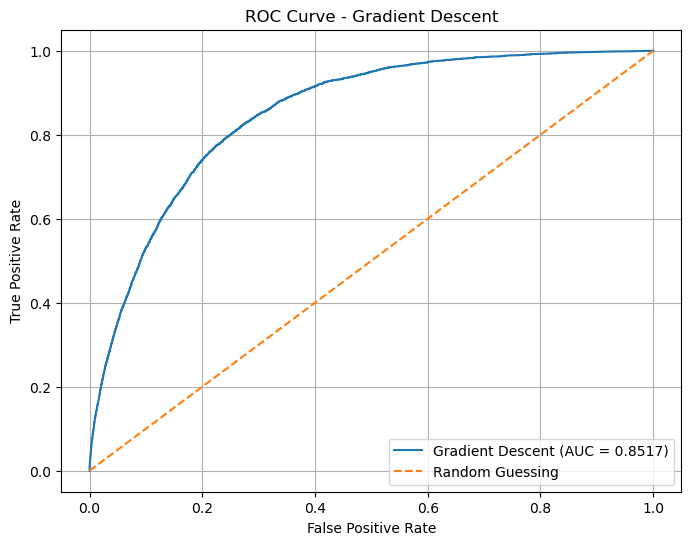

In [3]:
# Define a range of gamma values to test
gamma_values = [0.005, 0.01, 0.015, 0.02]

# Initialize variables to store the best parameters
best_gamma = None
best_threshold = None
best_f1 = 0
best_w = None
best_auc = 0
best_fpr = None
best_tpr = None

# Loop over gamma values
for gamma in gamma_values:
    print(f"Testing gamma: {gamma}")
    # Initialize weights
    initial_w = np.zeros(X_train.shape[1])
    # Train the model
    w, loss = mean_squared_error_gd(y_train, X_train, initial_w, max_iters=1000, gamma=gamma)

    # Compute predicted scores on the validation set
    y_scores = X_test @ w

    # Optimize threshold for the current gamma
    threshold, f1, acc = optimize_threshold(y_test, y_scores)

    print(f"Gamma: {gamma}, Best Threshold: {threshold}, F1 Score: {f1}, Accuracy: {acc}")
    # Compute ROC and AUC
    y_test_binary = (y_test + 1) // 2  # Convert -1/1 labels to 0/1
    fpr, tpr, thresholds, auc = compute_roc_auc(y_test_binary, y_scores)
    print(f"Gamma: {gamma}, AUC: {auc}")

    # Update best parameters if current F1 is better
    if f1 > best_f1:
        best_f1 = f1
        best_gamma = gamma
        best_threshold = threshold
        best_w = w.copy()
        best_auc = auc
        best_fpr = fpr
        best_tpr = tpr

# After finding the best gamma and threshold, make predictions on the test set
y_scores = X_test @ best_w
y_prediction = np.where(y_scores >= best_threshold, 1, -1)

# Compute final accuracy and F1 score
final_accuracy = accuracy(y_test, y_prediction)
final_f1_score = f1_score(y_test, y_prediction)

# Display results
print("Best Gamma:", best_gamma)
print("Best Threshold:", best_threshold)
print("Final Accuracy:", final_accuracy)
print("Final F1 Score:", final_f1_score)
plot_roc_curve(best_fpr, best_tpr, best_auc, model_name='Gradient Descent')


# Stochastic Gradient Descent

Testing gamma: 0.0015
Current iteration=0, loss=0.43188465633820855
Current iteration=100, loss=0.15611042859884317
Current iteration=200, loss=0.15562761880736284
Current iteration=300, loss=0.14676915553330233
Current iteration=400, loss=0.1672975793604043
Current iteration=500, loss=0.14397916505692704
Current iteration=600, loss=0.14206171455176092
Current iteration=700, loss=0.14547235643328577
Current iteration=800, loss=0.14092201380148406
Current iteration=900, loss=0.14091381148980492
Gamma: 0.0015, Best Threshold: -0.6477302863269224, F1 Score: 0.38450310181243164, Accuracy: 0.8457951757660719
Gamma: 0.0015, AUC: 0.8314485504623403
Best Gamma: 0.0015
Best Threshold: -0.6477302863269224
Final F1 Score: 0.38450310181243164


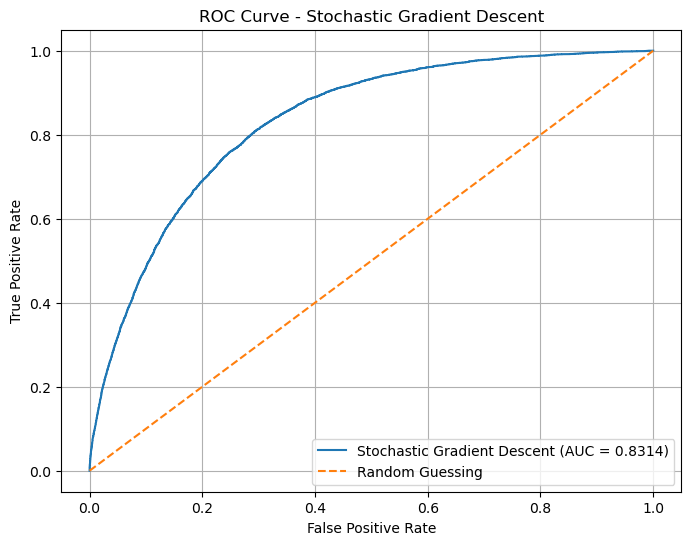

In [4]:
# Define a range of gamma values to test
gamma_values = [0.0015]

# Initialize variables to store the best parameters
best_gamma = None
best_threshold = None
best_f1 = 0
best_w = None
best_auc = 0
best_fpr = None
best_tpr = None

# Loop over gamma values
for gamma in gamma_values:
    print(f"Testing gamma: {gamma}")
    # Initialize weights
    initial_w = np.zeros(X_train.shape[1])
    # Train the model
    w, loss = mean_squared_error_sgd(y_train, X_train, initial_w, max_iters=1000, gamma=gamma)

    # Compute predicted scores on the validation set
    y_scores = X_test @ w

    # Optimize threshold for the current gamma
    threshold, f1, acc = optimize_threshold(y_test, y_scores)
    print(f"Gamma: {gamma}, Best Threshold: {threshold}, F1 Score: {f1}, Accuracy: {acc}")

    # Compute ROC and AUC
    y_test_binary = (y_test + 1) // 2  # Convert -1/1 labels to 0/1
    fpr, tpr, thresholds, auc = compute_roc_auc(y_test_binary, y_scores)
    print(f"Gamma: {gamma}, AUC: {auc}")
    # Update best parameters if current F1 is better
    if f1 > best_f1:
        best_f1 = f1
        best_gamma = gamma
        best_threshold = threshold
        best_w = w.copy()
        best_auc = auc
        best_fpr = fpr
        best_tpr = tpr

# After finding the best gamma and threshold, make predictions on the test set
y_scores = X_test @ best_w
y_prediction = np.where(y_scores >= best_threshold, 1, -1)

# Compute final accuracy and F1 score
final_f1_score = f1_score(y_test, y_prediction)

# Display results
print("Best Gamma:", best_gamma)
print("Best Threshold:", best_threshold)
print("Final F1 Score:", final_f1_score)
plot_roc_curve(best_fpr, best_tpr, best_auc, model_name='Stochastic Gradient Descent')


# Least Squares

/Users/mehdibouchoucha/Desktop/ML/AmelProject/implementations.py:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  w=np.linalg.lstsq(A,b)[0]


Best AUC: 0.8535110626310611
Best Threshold: -0.5670693947456843
Final Accuracy: 0.8651926798421381
Final F1 Score: 0.41313432835820896


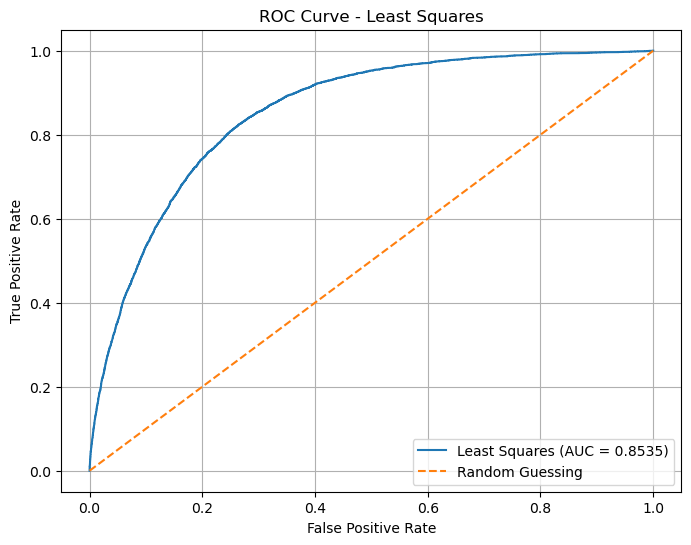

In [10]:
# Train the model
w, loss = least_squares(y_train, X_train)

# Compute predicted scores on the validation set
y_scores = X_test @ w

# Optimize threshold for the current gamma
threshold, f1, acc = optimize_threshold(y_test, y_scores)

# After finding the best gamma and threshold, make predictions on the test set
y_scores = X_test @ w
y_prediction = np.where(y_scores >= threshold, 1, -1)

# Compute final accuracy and F1 score
final_accuracy = accuracy(y_test, y_prediction)
final_f1_score = f1_score(y_test, y_prediction)

# Compute ROC and AUC
y_test_binary = (y_test + 1) // 2  # Convert -1/1 labels to 0/1
fpr, tpr, thresholds, auc = compute_roc_auc(y_test_binary, y_scores)

# Display results 
print("Best AUC:", auc)
print("Best Threshold:", threshold)
print("Final Accuracy:", final_accuracy)
print("Final F1 Score:", final_f1_score)

# Plot ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'Least Squares (AUC = {auc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', label='Random Guessing')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Least Squares')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Ridge Regression

Testing lambda: 0.005
Gamma: 0.9, Best Threshold: -0.5786245959336018, F1 Score: 0.4106614017769003, Accuracy: 0.8635470157099974
Lambda: 0.005, AUC: 0.8519647007002763
Testing lambda: 0.01
Gamma: 0.9, Best Threshold: -0.5782330978537572, F1 Score: 0.41038171971998416, Accuracy: 0.8639584317430326
Lambda: 0.01, AUC: 0.8521547674532928
Testing lambda: 0.015
Gamma: 0.9, Best Threshold: -0.5778854457415188, F1 Score: 0.41129673826571206, Accuracy: 0.864689838023984
Lambda: 0.015, AUC: 0.8522533148505771
Testing lambda: 0.02
Gamma: 0.9, Best Threshold: -0.5753453598351297, F1 Score: 0.41125251172136634, Accuracy: 0.866061224800768
Lambda: 0.02, AUC: 0.8522613827852275
Best Lambda: 0.015
Best Threshold: -0.5778854457415188
Final F1 Score: 0.41129673826571206


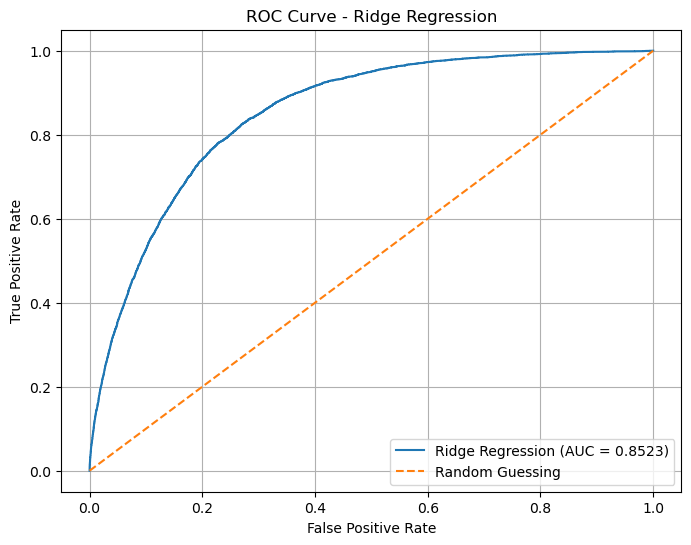

In [11]:
# Define a range of lambda values to test
lambda_values = [0.005, 0.01 , 0.015, 0.02]

# Initialize variables to store the best parameters
best_lambda = None
best_threshold = None
best_f1 = -1
best_w = None
best_auc = 0
best_fpr = None
best_tpr = None

# Loop over lambda values
for lambda_ in lambda_values:
    print(f"Testing lambda: {lambda_}")
    # Train the model
    w, loss = ridge_regression(y_train, X_train, lambda_)
    
    # Compute predicted scores on the test set
    y_scores = X_test @ w  # Continuous scores
    
    # Optimize threshold for the current lambda
    threshold, f1, acc = optimize_threshold(y_test, y_scores)
    print(f"Gamma: {gamma}, Best Threshold: {threshold}, F1 Score: {f1}, Accuracy: {acc}")
    
    # Compute ROC and AUC
    y_test_binary = (y_test + 1) // 2  # Convert -1/1 labels to 0/1
    fpr, tpr, thresholds, auc = compute_roc_auc(y_test_binary, y_scores)
    print(f"Lambda: {lambda_}, AUC: {auc}")
    # Update best parameters if current F1 is better
    if f1 > best_f1:
        best_f1 = f1
        best_lambda = lambda_
        best_threshold = threshold
        best_w = w.copy()
        best_auc = auc
        best_fpr = fpr
        best_tpr = tpr

# After finding the best lambda and threshold, make predictions on the test set
y_scores = X_test @ best_w
y_pred = np.where(y_scores >= best_threshold, 1, -1)

# Compute final F1 score
final_f1_score = f1_score(y_test, y_pred)

# Display results
print("Best Lambda:", best_lambda)
print("Best Threshold:", best_threshold)
print("Final F1 Score:", final_f1_score)
plot_roc_curve(best_fpr, best_tpr, best_auc, model_name='Ridge Regression')


# Logistic Regression

Testing gamma: 0.9
Current iteration=0, loss=1.580226449126937
Current iteration=100, loss=0.32482471721749684
Current iteration=200, loss=0.3391803220447881
Current iteration=300, loss=0.2693260509636259
Current iteration=400, loss=0.2942305602379432
Current iteration=500, loss=0.2557766921885954
Current iteration=600, loss=0.28532196319066044
Current iteration=700, loss=0.2554614885016538
Current iteration=800, loss=0.2843560949045877
Current iteration=900, loss=0.25585764983762965
Gamma: 0.9, Best Threshold: 0.30303030303030304, F1 Score: 0.42230278784848113
Gamma: 0.9, AUC: 0.8589977430872945
Best Gamma: 0.9
Best Threshold: 0.30303030303030304
Final F1 Score: 0.42230278784848113


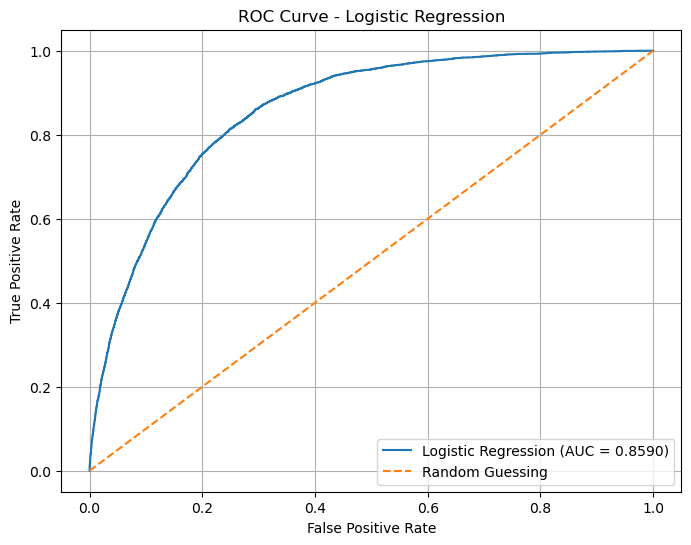

In [12]:
# Convert y_train and y_test to binary labels (0 and 1)
y_train_binary = (y_train + 1) // 2
y_test_binary = (y_test + 1) // 2

# Define a range of gamma values to test
gamma_values = [0.9]

# Initialize variables to store the best parameters
best_gamma = None
best_threshold = None
best_f1 = 0
best_w = None
best_auc = 0
best_fpr = None
best_tpr = None

# Loop over gamma values
for gamma in gamma_values:
    print(f"Testing gamma: {gamma}")
    # Initialize weights
    initial_w = np.zeros(X_train.shape[1])
    # Train the model
    w, loss = logistic_regression(y_train_binary, X_train, initial_w, max_iters=1000, gamma=gamma)
    
    # Compute predicted probabilities on the validation set
    y_scores = sigmoid(X_test @ w)
    
    # Optimize threshold for the current gamma
    threshold, f1 = optimize_threshold_logistic(y_test_binary, y_scores)
    print(f"Gamma: {gamma}, Best Threshold: {threshold}, F1 Score: {f1}")

    # Compute ROC and AUC
    fpr, tpr, thresholds, auc = compute_roc_auc(y_test_binary, y_scores)
    print(f"Gamma: {gamma}, AUC: {auc}")
    # Update best parameters if current F1 is better
    if f1 > best_f1:
        best_f1 = f1
        best_gamma = gamma
        best_threshold = threshold
        best_w = w.copy()
        best_auc = auc
        best_fpr = fpr
        best_tpr = tpr

# After finding the best gamma and threshold, make predictions on the test set
y_scores = sigmoid(X_test @ best_w)
y_prediction_binary = np.where(y_scores >= best_threshold, 1, 0)
y_prediction = y_prediction_binary * 2 - 1  # Convert back to -1 and 1

# Compute final accuracy and F1 score
final_f1_score = f1_score_logistic(y_test_binary, y_prediction_binary)

# Display results
print("Best Gamma:", best_gamma)
print("Best Threshold:", best_threshold)
print("Final F1 Score:", final_f1_score)
plot_roc_curve(best_fpr, best_tpr, best_auc, model_name='Logistic Regression')


# Regularized Logistic Regression

Testing gamma: 0.9, lambda: 0.0001
Current iteration=0, loss=1.580926190366109 (with regularization)
Current iteration=100, loss=0.25310248661438456 (with regularization)
Current iteration=200, loss=0.3810539437599975 (with regularization)
Current iteration=300, loss=0.36750626878536896 (with regularization)
Current iteration=400, loss=0.38258974982361066 (with regularization)
Current iteration=500, loss=0.40461582835656396 (with regularization)
Current iteration=600, loss=0.3800112928687103 (with regularization)
Current iteration=700, loss=0.40224673244121306 (with regularization)
Current iteration=800, loss=0.3720865397839348 (with regularization)
Current iteration=900, loss=0.39900342153832924 (with regularization)
Gamma: 0.9, Lambda: 0.0001, Best Threshold: 0.393939393939394, F1 Score: 0.42220835932626327
Gamma: 0.9, Lambda: 0.0001, AUC: 0.8585854634477256
Best Gamma: 0.9
Best Lambda: 0.0001
Best Threshold: 0.393939393939394
Final F1 Score: 0.42220835932626327


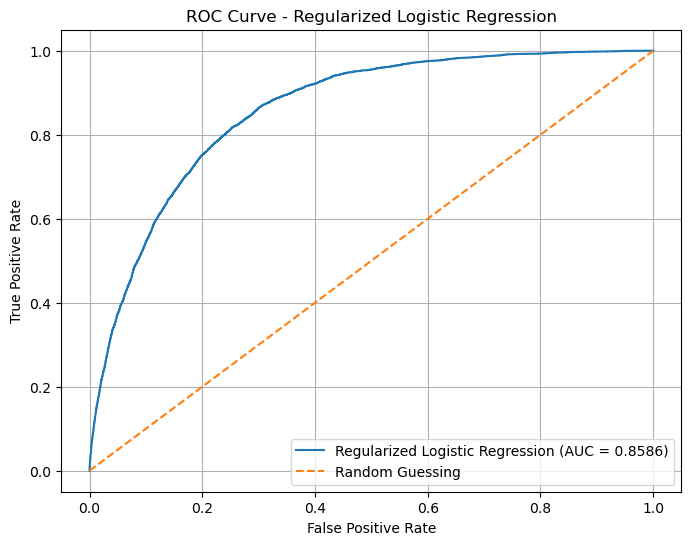

In [16]:
# Convert y_train and y_test to binary labels (0 and 1)
y_train_binary = (y_train + 1) // 2
y_test_binary = (y_test + 1) // 2

# Define a range of gamma and lambda values to test
gamma_values = [0.9]
lambda_values = [0.0001]

# Initialize variables to store the best parameters
best_gamma = None
best_lambda = None
best_threshold = None
best_f1 = -1
best_w = None

# Loop over gamma and lambda values
for gamma in gamma_values:
    for lambda_ in lambda_values:
        print(f"Testing gamma: {gamma}, lambda: {lambda_}")
        # Initialize weights
        initial_w = np.zeros(X_train.shape[1])
        # Train the model
        w, loss = reg_logistic_regression(
            y_train_binary, X_train, lambda_, initial_w, max_iters=1000, gamma=gamma
        )
        
        # Compute predicted probabilities on the test set
        y_scores = sigmoid(X_test @ w)
        
        # Optimize threshold for the current gamma and lambda
        threshold, f1 = optimize_threshold_logistic(y_test_binary, y_scores)
        print(f"Gamma: {gamma}, Lambda: {lambda_}, Best Threshold: {threshold}, F1 Score: {f1}")

        # Compute ROC and AUC
        fpr, tpr, thresholds, auc = compute_roc_auc(y_test_binary, y_scores)
        print(f"Gamma: {gamma}, Lambda: {lambda_}, AUC: {auc}")
        # Update best parameters if current F1 is better
        if f1 > best_f1:
            best_f1 = f1
            best_gamma = gamma
            best_lambda = lambda_
            best_threshold = threshold
            best_w = w.copy()
            best_auc = auc
            best_fpr = fpr
            best_tpr = tpr

# After finding the best gamma, lambda, and threshold, make predictions on the test set
y_scores = sigmoid(X_test @ best_w)
y_prediction_binary = np.where(y_scores >= best_threshold, 1, 0)
y_prediction = y_prediction_binary * 2 - 1  # Convert back to -1 and 1

# Compute final F1 score
final_f1_score = f1_score_logistic(y_test_binary, y_prediction_binary)

# Display results
print("Best Gamma:", best_gamma)
print("Best Lambda:", best_lambda)
print("Best Threshold:", best_threshold)
print("Final F1 Score:", final_f1_score)
plot_roc_curve(best_fpr, best_tpr, best_auc, model_name='Regularized Logistic Regression')